## The Spiral Untangler
In this project we'll be building a neural network from scratch that learns to classify **intertwined spirals**, with real-time visualization of how each layer geometrically transforms the data space.

### 1- Data generation and understanding :
1.1 Generating simple spirals

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spiral(n_points=100, bias=0.5, rate=0.3, rotations=2, clockwise=0):
    """Generates a single spiral dataset"""
    theta = np.linspace(0, rotations * 2 * np.pi, n_points)
    
    if clockwise == 0:  # counter-clockwise
        r = bias + rate * theta  # Archimedean spiral
    else:  # clockwise
        theta = -theta
        r = bias + rate * (-theta)
        
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    return np.column_stack([x, y])

def generate_intertwined_spirals(n_points=100, difficulty='easy'):
    """Generates two intertwined spirals with varying difficulties"""
    
    if difficulty == 'easy':
        # Easy: spirals start from different radii, barely overlap
        spiral1 = generate_spiral(n_points=n_points, bias=0.3, rate=0.2, rotations=2, clockwise=0)
        spiral2 = generate_spiral(n_points=n_points, bias=0.8, rate=0.2, rotations=2, clockwise=1)
        
    elif difficulty == 'medium':
        # Medium: spirals start closer together
        spiral1 = generate_spiral(n_points=n_points, bias=0.2, rate=0.3, rotations=3, clockwise=0)
        spiral2 = generate_spiral(n_points=n_points, bias=0.4, rate=0.3, rotations=3, clockwise=1)
        
    elif difficulty == 'hard':
        # Hard: spirals start very close, many rotations
        spiral1 = generate_spiral(n_points=n_points, bias=0.1, rate=0.2, rotations=4, clockwise=0)
        spiral2 = generate_spiral(n_points=n_points, bias=0.2, rate=0.2, rotations=4, clockwise=1)
        
    # Create labels: spiral1 = class 0, spiral2 = class 1
    labels1 = np.zeros(n_points)
    labels2 = np.ones(n_points)
    
    # Combine data
    X = np.vstack([spiral1, spiral2])
    y = np.hstack([labels1, labels2])
    
    return X, y

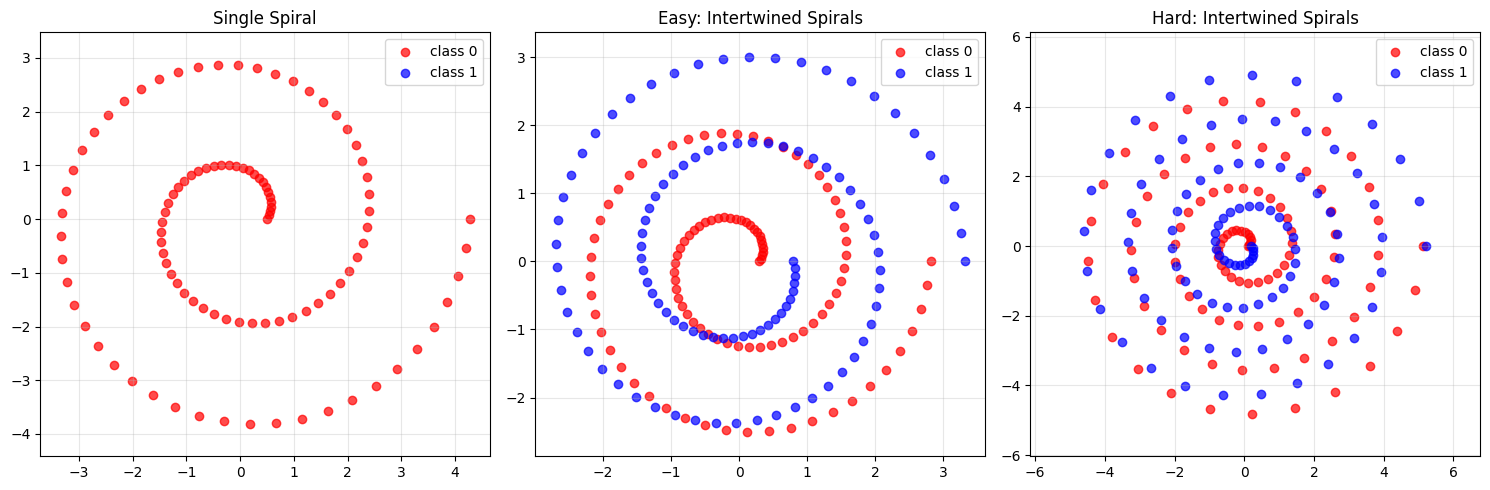


Easy dataset shape: (200, 2)    labels shape: (200,)
Hard dataset shape: (200, 2)    labels shape: (200,)


In [2]:
# Testing : 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = [
    (generate_spiral(), np.zeros(len(generate_spiral())), "Single Spiral"),
    *[generate_intertwined_spirals(difficulty=d) + (f"{d.capitalize()}: Intertwined Spirals",) 
      for d in ["easy", "hard"]]
]

for ax, (X, y, title) in zip(axes, datasets):
    ax.scatter(X[y==0, 0], X[y==0, 1], c='red', alpha=0.7, label='class 0')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='blue', alpha=0.7, label='class 1')
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

X_easy, y_easy = generate_intertwined_spirals(difficulty='easy')
X_hard, y_hard = generate_intertwined_spirals(difficulty='hard')
print()
print(f"Easy dataset shape: {X_easy.shape}    labels shape: {y_easy.shape}")
print(f"Hard dataset shape: {X_hard.shape}    labels shape: {y_hard.shape}")

2.2 Visualization :

In [3]:
import matplotlib.pyplot as plt

def plot_data(X, y, title="Graph"):
    """Plot 2D data points with different colors for classes"""
    plt.figure(figsize=(6, 6))
    
    # Plot Class 0
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', s=1, alpha=0.7, label='class 0')
    
    # Plot Class 1
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', s=1, alpha=0.7, label='class 1')
    
    plt.title(title)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

### 2- Neural Network :
2.1 Core building blocks :

In [8]:
def init_params():     
    """Xavier initialization of initial parameters"""
    # Layer 1: 2 inputs -> 4 hidden neurons
    w1 = np.random.randn(4, 2) * 0.1
    b1 = np.zeros((4, 1))             

    # Small weights > tanh stays in the linear region > gradients flow well
    
    # Layer 2: 4 hidden -> 1 output neuron  
    w2 = np.random.randn(1, 4) * 0.1
    b2 = np.zeros((1, 1))             
    
    return w1, b1, w2, b2

def sigmoid(z):
    # We'll clip z to prevent overflow
    z = np.clip(z, -500, 500)
    return 1/(1 + np.exp(-z))

def forward_prop(w1, b1, w2, b2, X):
    # X shape: (m, 2) -> transpose to (2, m)
    X = X.T
    m = X.shape[1]  
    
    # Layer 1
    z1 = w1.dot(X) + b1  # Shape: (4, m)
    A1 = np.tanh(z1)     # Shape: (4, m)
    
    # Layer 2  
    z2 = w2.dot(A1) + b2 # Shape: (1, m)
    A2 = sigmoid(z2)     # Shape: (1, m)

    return z1, A1, z2, A2 

def back_prop(z1, A1, z2, A2, w1, w2, X, Y):    
    """Fixed backpropagation - the issue was X wasn't transposed in back_prop"""
    # X needs to be transposed to match forward prop: shape (2, m)
    X = X.T  
    m = Y.shape[1]
    
    # LAYER 2 GRADIENTS:
    dL_dA2 = 2 * (A2 - Y)
    dA2_dz2 = A2 * (1 - A2)
    dL_dz2 = dL_dA2 * dA2_dz2
    
    dL_dw2 = (1/m) * dL_dz2.dot(A1.T)  # Shape: (1, 4)
    dL_db2 = (1/m) * np.sum(dL_dz2, axis=1, keepdims=True)  # Shape: (1, 1)
    
    # LAYER 1 GRADIENTS:
    dL_dA1 = w2.T.dot(dL_dz2)  # Shape: (4, m)
    dA1_dz1 = 1 - A1**2
    dL_dz1 = dL_dA1 * dA1_dz1
    
    dL_dw1 = (1/m) * dL_dz1.dot(X.T)  # Shape: (4, 2)
    dL_db1 = (1/m) * np.sum(dL_dz1, axis=1, keepdims=True)  # Shape: (4, 1)
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2

def update_params(w1, b1, w2, b2, dL_dw1, dL_db1, dL_dw2, dL_db2, learning_rate):
    """Update parameters using gradient descent"""
    w1 = w1 - learning_rate * dL_dw1
    b1 = b1 - learning_rate * dL_db1
    w2 = w2 - learning_rate * dL_dw2
    b2 = b2 - learning_rate * dL_db2
    
    return w1, b1, w2, b2

def compute_cost(A2, Y):
    """Compute mean squared error cost"""
    m = Y.shape[1]
    cost = (1/m) * np.sum((A2 - Y)**2)
    return cost

Training loop

In [9]:
def train_network(X, y, epochs=1000, learning_rate=0.01, print_cost=True):
    """Train the neural network"""
    # Initialize parameters
    w1, b1, w2, b2 = init_params()
    
    # Reshape y to match our forward prop expectations
    Y = y.reshape(1, -1)  # Shape: (1, m)
    
    costs = []
    
    for i in range(epochs):
        # Forward propagation
        z1, A1, z2, A2 = forward_prop(w1, b1, w2, b2, X)
        
        # Compute cost
        cost = compute_cost(A2, Y)
        costs.append(cost)
        
        # Backward propagation
        dL_dw1, dL_db1, dL_dw2, dL_db2 = back_prop(z1, A1, z2, A2, w1, w2, X, Y)
        
        # Update parameters
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dL_dw1, dL_db1, dL_dw2, dL_db2, learning_rate)
        
        # Print cost every 100 iterations
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
    
    # Return trained parameters and cost history
    return (w1, b1, w2, b2), costs

def plot_decision_boundary(params, X, y, resolution=100, title="Decision Boundary"):
    """Plot the decision boundary of a trained model"""
    w1, b1, w2, b2 = params
    
    # Create a mesh of points
    h = 0.1  # step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Flatten the mesh and make predictions
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    _, _, _, A2 = forward_prop(w1, b1, w2, b2, mesh_points)
    A2 = A2.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, A2, levels=50, alpha=0.8, cmap='RdYlBu')
    plt.colorbar(label='Network Output')
    plt.contour(xx, yy, A2, levels=[0.5], colors='black', linestyles='--', linewidths=2)
    
    # Plot the data points
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', s=20, edgecolors='black', alpha=0.7, label='Class 0')
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', s=20, edgecolors='black', alpha=0.7, label='Class 1')
    
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Testing the network :

TRAINING ON MEDIUM SPIRALS
Cost after iteration 0: 0.25110740795420744
Cost after iteration 100: 0.24931890615421445
Cost after iteration 200: 0.24801250110031386
Cost after iteration 300: 0.24698258596311337
Cost after iteration 400: 0.2462824040346398
Cost after iteration 500: 0.24583332093397287
Cost after iteration 600: 0.24551238000915085
Cost after iteration 700: 0.2452422321859146
Cost after iteration 800: 0.24498787113788006
Cost after iteration 900: 0.2447336764944638
Cost after iteration 1000: 0.24447025878348688
Cost after iteration 1100: 0.24418968774203867
Cost after iteration 1200: 0.24388431541255687
Cost after iteration 1300: 0.2435467766664362
Cost after iteration 1400: 0.24317031207513742
Cost after iteration 1500: 0.24274911586285003
Cost after iteration 1600: 0.24227854743365254
Cost after iteration 1700: 0.24175509234762255
Cost after iteration 1800: 0.24117604294385436
Cost after iteration 1900: 0.24053900499848174

Final accuracy on easy spirals: 0.583


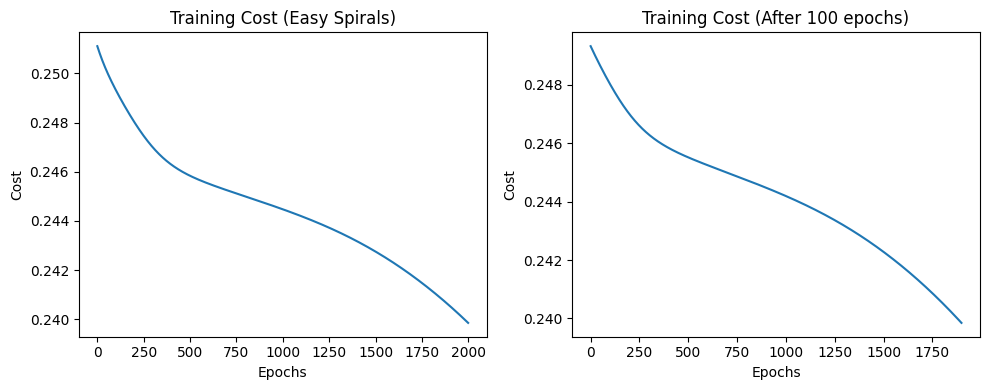

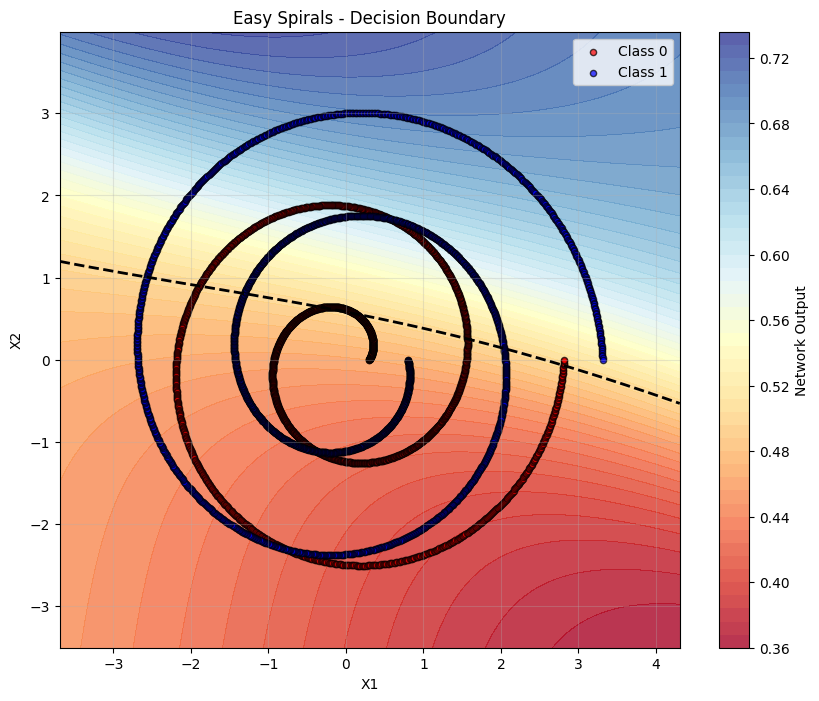


NOW TRYING HARD SPIRALS
Cost after iteration 0: 0.25041004585589977
Cost after iteration 100: 0.2489164828171305
Cost after iteration 200: 0.24840039549963455
Cost after iteration 300: 0.24822854577962075
Cost after iteration 400: 0.24816881381906022
Cost after iteration 500: 0.2481421071074924
Cost after iteration 600: 0.2481251179602269
Cost after iteration 700: 0.24811149618781117
Cost after iteration 800: 0.24809953202600146
Cost after iteration 900: 0.24808872879576904
Cost after iteration 1000: 0.24807890110479094
Cost after iteration 1100: 0.2480699433152119
Cost after iteration 1200: 0.24806177161227708
Cost after iteration 1300: 0.24805431032701009
Cost after iteration 1400: 0.24804748917233596
Cost after iteration 1500: 0.24804124293886176
Cost after iteration 1600: 0.24803551159199955
Cost after iteration 1700: 0.24803024031813245
Cost after iteration 1800: 0.2480253794514771
Cost after iteration 1900: 0.2480208842959457

Final accuracy on hard spirals: 0.500


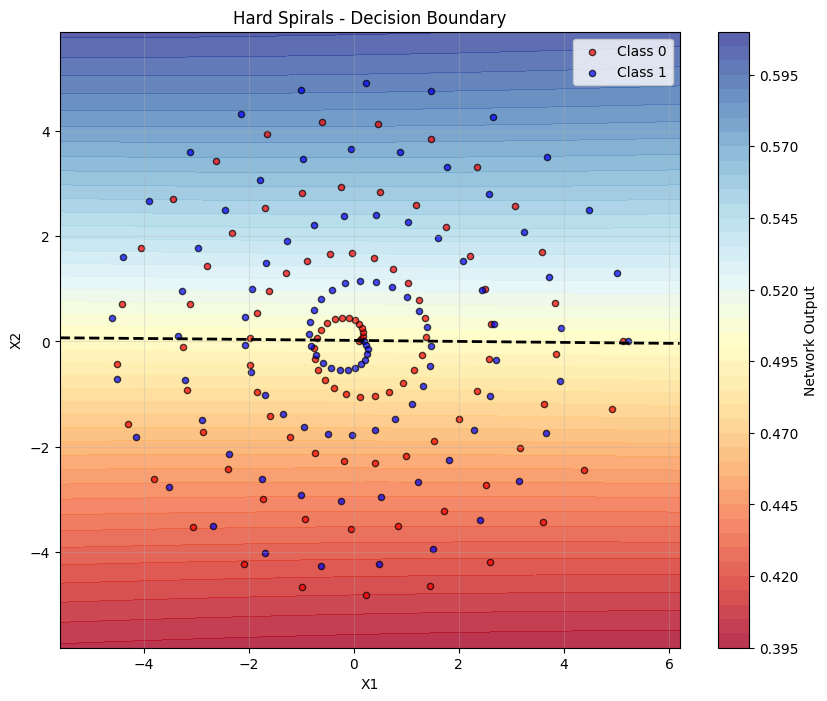

In [12]:
def calculate_accuracy(params, X, y):
    """Calculate classification accuracy"""
    w1, b1, w2, b2 = params
    _, _, _, A2 = forward_prop(w1, b1, w2, b2, X)
    predictions = (A2 > 0.5).astype(int).flatten()
    accuracy = np.mean(predictions == y)
    return accuracy

print("TRAINING ON MEDIUM SPIRALS")
X_easy, y_easy = generate_intertwined_spirals(n_points=2000, difficulty='easy')
easy_params, easy_costs = train_network(X_easy, y_easy, epochs=2000, learning_rate=0.1)

print(f"\nFinal accuracy on easy spirals: {calculate_accuracy(easy_params, X_easy, y_easy):.3f}")

# Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(easy_costs)
plt.title('Training Cost (Easy Spirals)')
plt.xlabel('Epochs')
plt.ylabel('Cost')

plt.subplot(1, 2, 2)
plt.plot(easy_costs[100:])  # Skip first 100 for better view
plt.title('Training Cost (After 100 epochs)')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()

# Plot decision boundary
plot_decision_boundary(easy_params, X_easy, y_easy, title="Easy Spirals - Decision Boundary")

print("\nNOW TRYING HARD SPIRALS")
hard_params, hard_costs = train_network(X_hard, y_hard, epochs=2000, learning_rate=0.1)

print(f"\nFinal accuracy on hard spirals: {calculate_accuracy(hard_params, X_hard, y_hard):.3f}")

plot_decision_boundary(hard_params, X_hard, y_hard, title="Hard Spirals - Decision Boundary")

The Impossibility dataset Demonstration
experiment with width
spiral challenge
layer by layer transformation visualization
animated training process
Investigate the homeomorphism properties
Understand where gradients are large/small and why
Novel Architecture Experiments
my own topologically challenging dataset